In [58]:
#!pip install wordcloud
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [59]:
data=pd.read_csv("ds_salaries.csv")

In [60]:
print(data.shape)

(3755, 11)


In [61]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [62]:
data.nunique()

work_year                4
experience_level         4
employment_type          4
job_title               93
salary                 815
salary_currency         20
salary_in_usd         1035
employee_residence      78
remote_ratio             3
company_location        72
company_size             3
dtype: int64

In [63]:
data.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [64]:
data.duplicated().sum()

1171

In [65]:
data = data.drop_duplicates()

In [66]:
data.duplicated().sum()

0

In [67]:
data.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [68]:
numerical_columns=data.select_dtypes(include=['int64']).columns
categorical_columns=data.select_dtypes(include=['object']).columns

In [69]:
numerical_columns

Index(['work_year', 'salary', 'salary_in_usd', 'remote_ratio'], dtype='object')

In [70]:
categorical_columns

Index(['experience_level', 'employment_type', 'job_title', 'salary_currency',
       'employee_residence', 'company_location', 'company_size'],
      dtype='object')

In [71]:
data.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [72]:
iso_forest=IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(data[numerical_columns])
outlier_count = (outliers == -1).sum()
total_count = len(outliers)
outlier_percentage = (outlier_count / total_count) * 100
print(f"Percentage of numerical outliers: {outlier_percentage:.2f}%")

Percentage of numerical outliers: 5.03%


In [73]:
cat_outliers = {}
cat_outlier_count = 0

for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outliers[col] = rare_categories.index.tolist()
    cat_outlier_count += data[col].isin(rare_categories.index).sum()

total_count = len(data)

categorical_outlier_percentage = (cat_outlier_count / total_count) * 100

print(f"Categorical outliers count: {cat_outlier_count}")
print(f"Categorical outliers percentage: {categorical_outlier_percentage:.2f}%")

Categorical outliers count: 2153
Categorical outliers percentage: 83.32%


In [74]:
cat_outliers = {}
cat_outlier_count = 0

# Identify outliers
for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outliers[col] = rare_categories.index.tolist()
    cat_outlier_count += data[col].isin(rare_categories.index).sum()

# Calculate total count and percentage of outliers
total_count = len(data)
categorical_outlier_percentage = (cat_outlier_count / total_count) * 100

print(f"Categorical outliers count before imputation: {cat_outlier_count}")
print(f"Categorical outliers percentage before imputation: {categorical_outlier_percentage:.2f}%")

# Impute outliers with mode
for col in categorical_columns:
    mode_value = data[col].mode()[0]  # Get the mode
    # Replace outliers with the mode
    data[col] = data[col].where(~data[col].isin(cat_outliers[col]), mode_value)

# Recalculate outliers after imputation
cat_outlier_count_after_imputation = 0

for col in categorical_columns:
    value_counts = data[col].value_counts()
    rare_categories = value_counts[value_counts < 0.05 * len(data)]
    cat_outlier_count_after_imputation += data[col].isin(rare_categories.index).sum()

# Calculate new percentage of outliers
categorical_outlier_percentage_after_imputation = (cat_outlier_count_after_imputation / total_count) * 100

print(f"Categorical outliers count after imputation: {cat_outlier_count_after_imputation}")
print(f"Categorical outliers percentage after imputation: {categorical_outlier_percentage_after_imputation:.2f}%")


Categorical outliers count before imputation: 2153
Categorical outliers percentage before imputation: 83.32%
Categorical outliers count after imputation: 0
Categorical outliers percentage after imputation: 0.00%


In [75]:
data['salary_category'] = pd.cut(
    data['salary_in_usd'],
    bins=[0, 100000, 200000, float('inf')],
    labels=['salary<100,000 USD', '100,000≤salary<200,000 USD', 'salary≥200,000 USD']
)

data[['salary_in_usd', 'salary_category']].head()


,salary_in_usd,salary_category
0,85847,"salary<100,000 USD"
1,30000,"salary<100,000 USD"
2,25500,"salary<100,000 USD"
3,175000,"100,000≤salary<200,000 USD"
4,120000,"100,000≤salary<200,000 USD"


In [76]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]
    
    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

data['job_category'] = data['job_title'].apply(assign_broader_category)


In [77]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_category,job_category
0,2023,SE,FT,Data Engineer,80000,EUR,85847,US,100,US,L,"salary<100,000 USD",Data Engineering
1,2023,MI,FT,Data Engineer,30000,USD,30000,US,100,US,S,"salary<100,000 USD",Data Engineering
2,2023,MI,FT,Data Engineer,25500,USD,25500,US,100,US,S,"salary<100,000 USD",Data Engineering
3,2023,SE,FT,Data Scientist,175000,USD,175000,US,100,US,M,"100,000≤salary<200,000 USD",Data Science
4,2023,SE,FT,Data Scientist,120000,USD,120000,US,100,US,M,"100,000≤salary<200,000 USD",Data Science


##  EDA

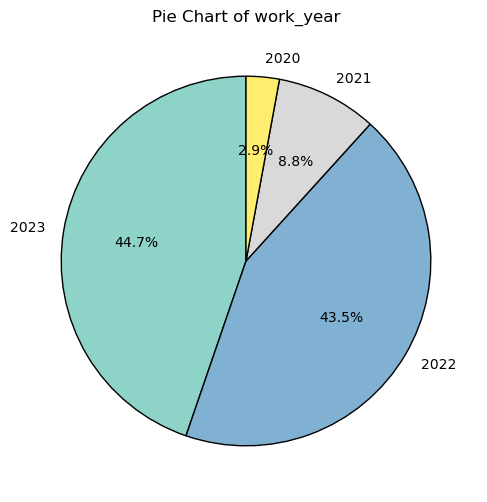

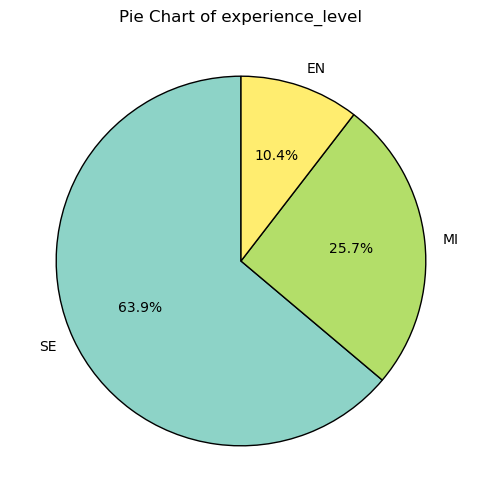

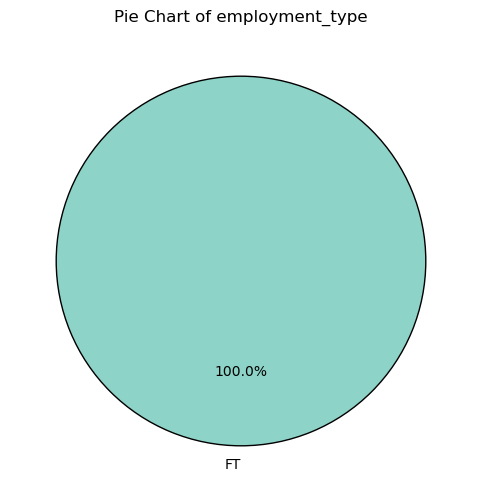

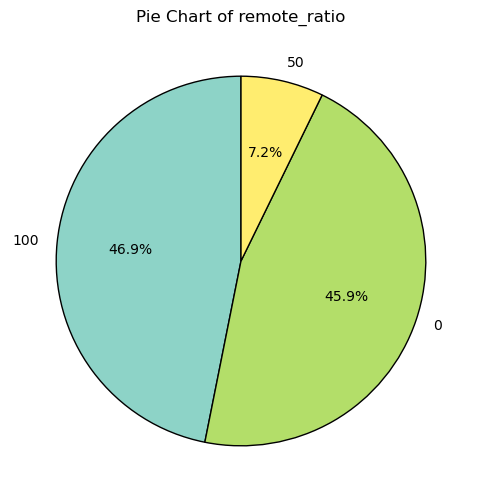

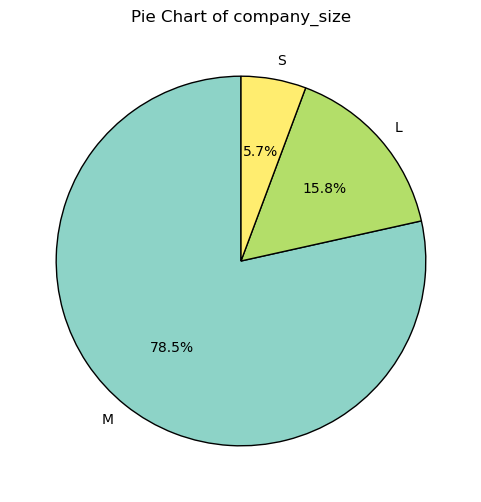

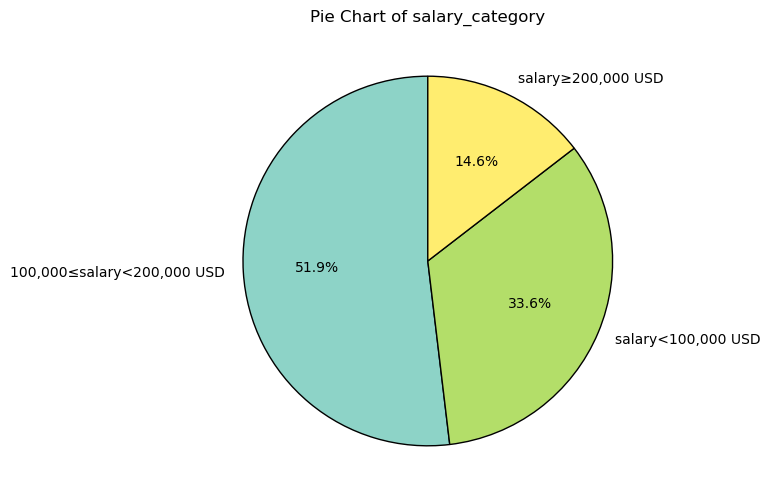

In [78]:
for col in ['work_year','experience_level','employment_type','remote_ratio','company_size','salary_category']:
    plt.figure(figsize=(6, 6))
    data[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', wedgeprops={'edgecolor': 'black'})
    plt.title(f"Pie Chart of {col}")
    plt.ylabel('') 
    plt.show()

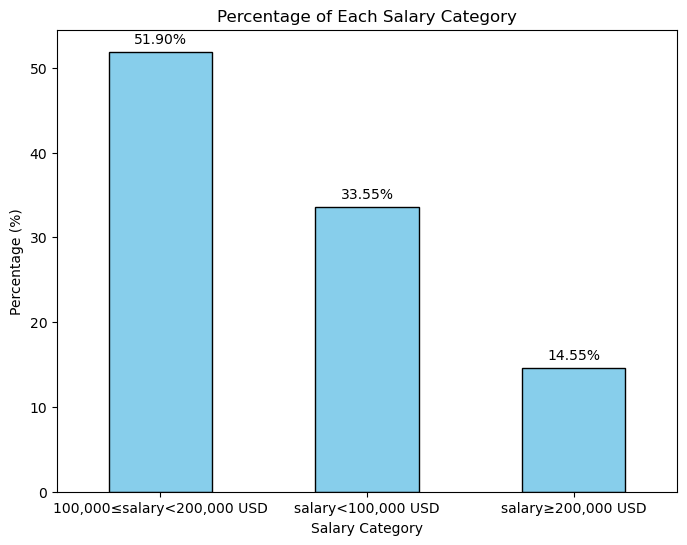

In [79]:
category_counts = data['salary_category'].value_counts(normalize=True) * 100

# Plot the bar chart
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Percentage of Each Salary Category')
plt.xlabel('Salary Category')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

# Display percentages on top of each bar
for index, value in enumerate(category_counts):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()

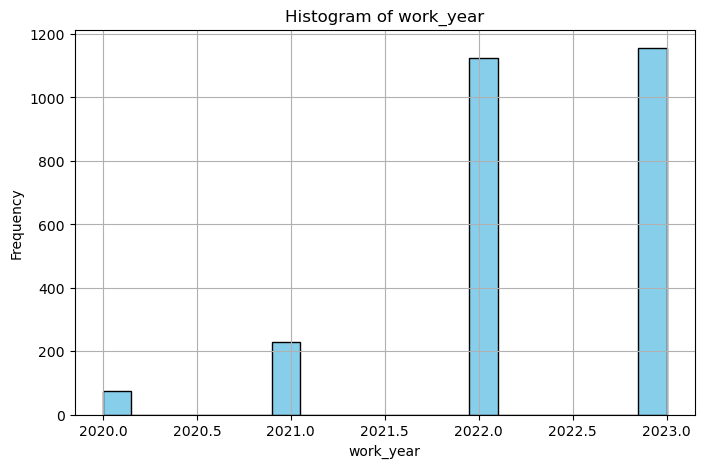

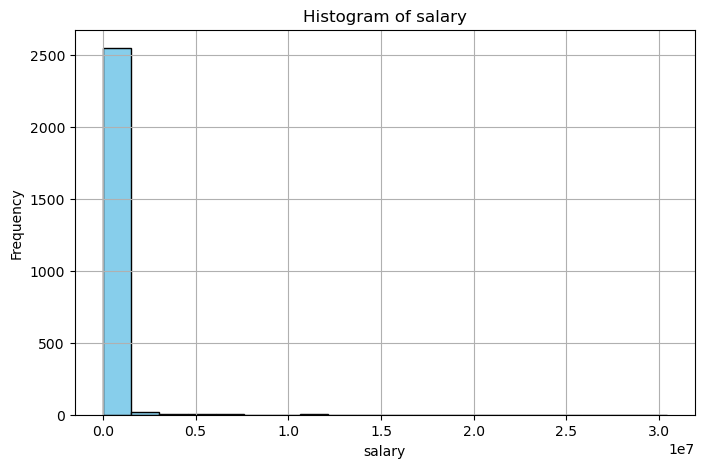

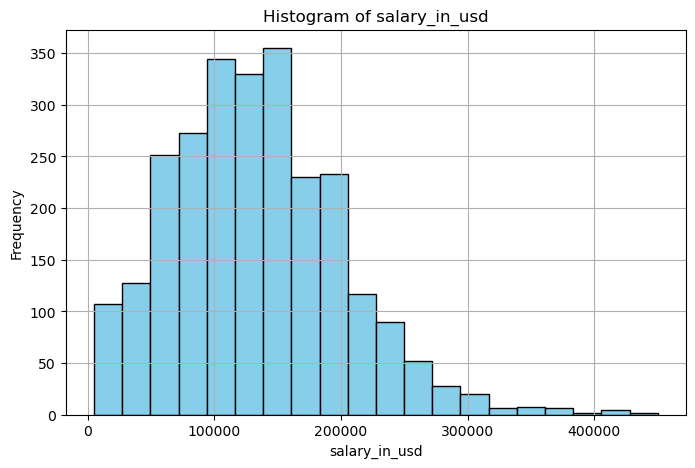

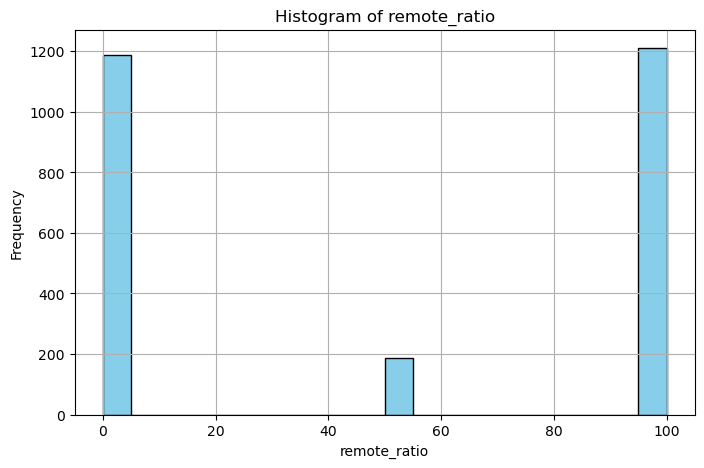

In [80]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(data[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

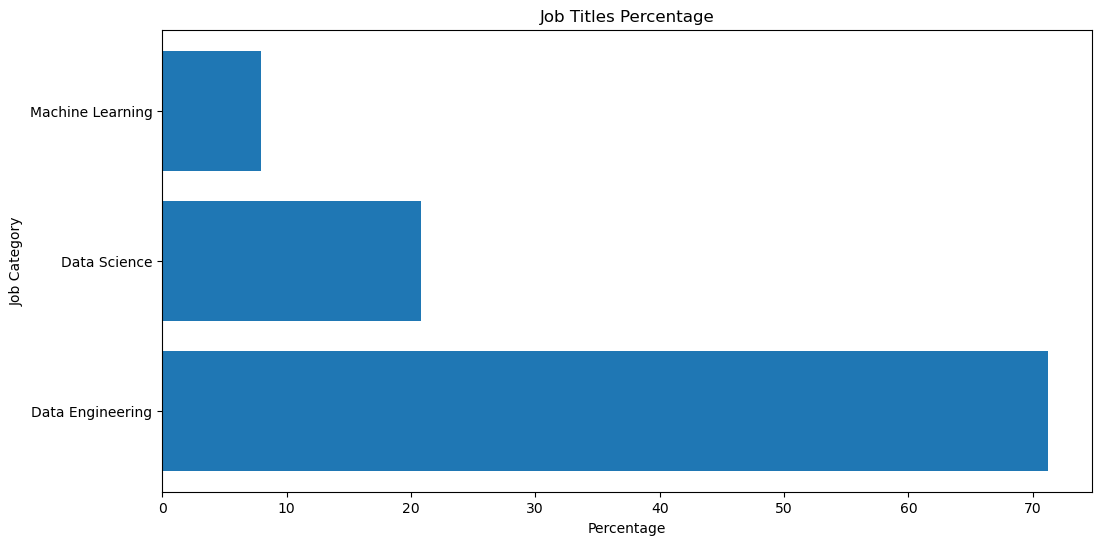

In [81]:
value_counts = data['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

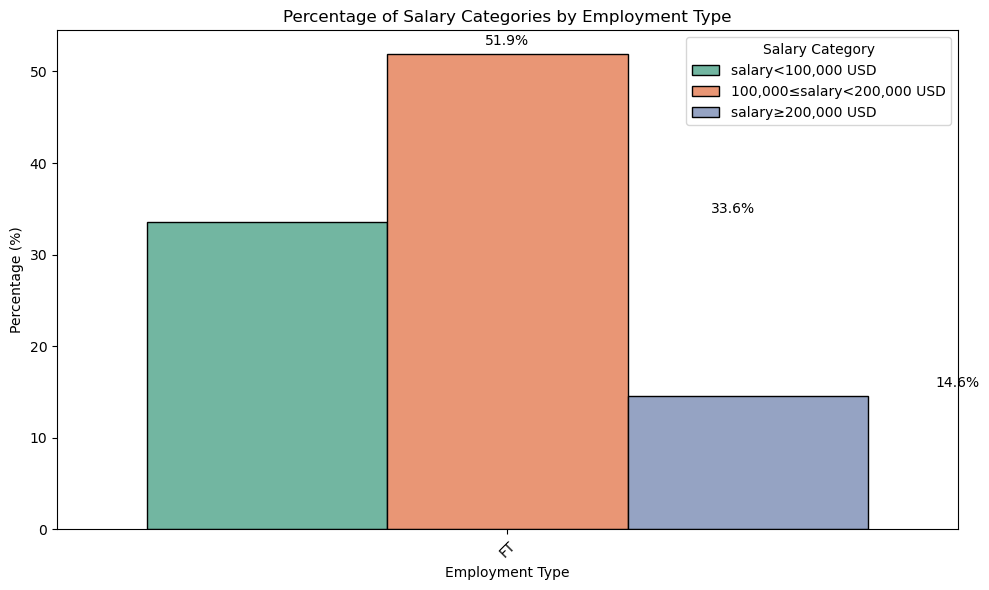

In [82]:
# Calculate the percentage of each salary category within each employment type
category_counts = (
    data.groupby('employment_type')['salary_category']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)
category_counts['percentage'] *= 100  # Convert to percentage

# Plot the multiple bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=category_counts,
    x='employment_type',
    y='percentage',
    hue='salary_category',
    palette='Set2',
    edgecolor='black'
)

# Add percentages on top of each bar
for index, row in category_counts.iterrows():
    plt.text(
        index // 3 + (index % 3) * 0.25,  # Adjust x position for multiple bars
        row['percentage'] + 1,
        f"{row['percentage']:.1f}%",
        ha='center'
    )

plt.title('Percentage of Salary Categories by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Salary Category', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Axes: xlabel='salary_in_usd', ylabel='Count'>

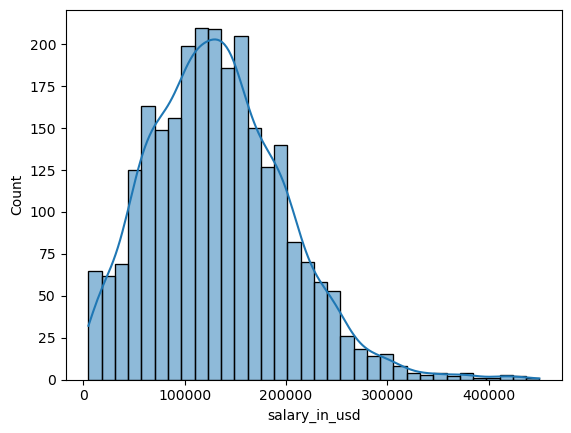

In [83]:
sns.histplot(data['salary_in_usd'], kde=True)

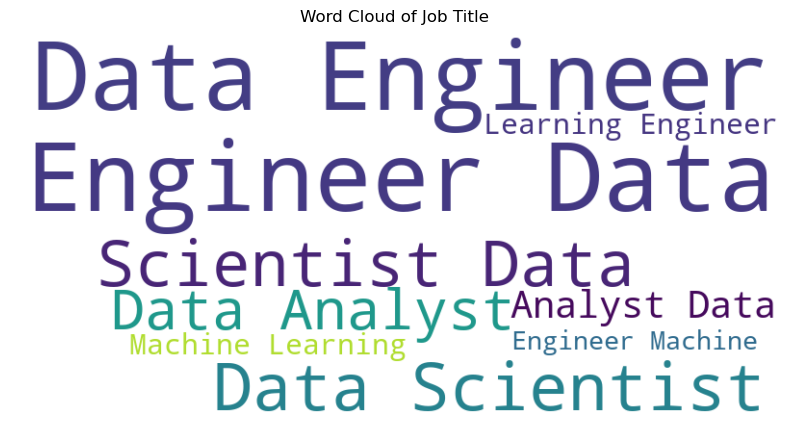

In [84]:
text_data = ' '.join(data['job_title'].dropna())  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud of Job Title')
plt.show()

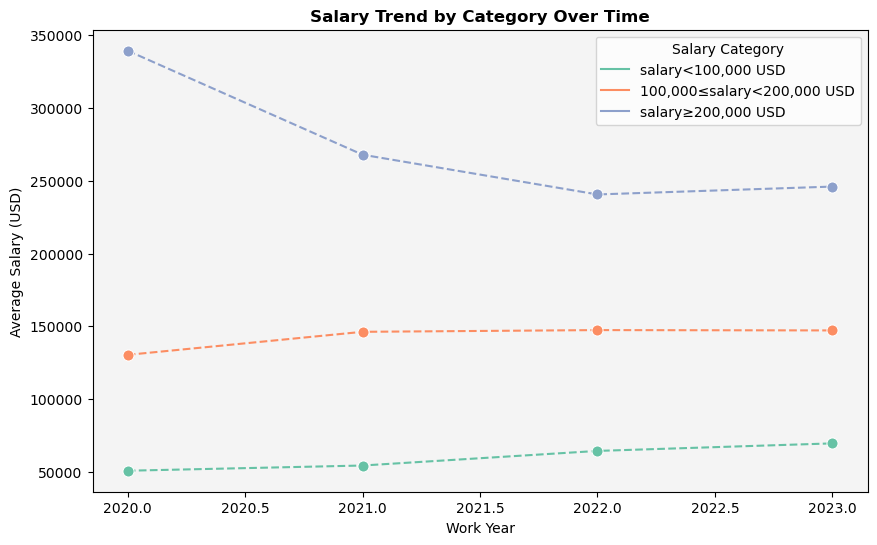

In [85]:
# Calculate the average salary per category for each year
salary_trend = data.groupby(['work_year', 'salary_category'])['salary_in_usd'].mean().reset_index()

plt.figure(figsize=(10, 6))
p = sns.lineplot(
    data=salary_trend,
    x='work_year',
    y='salary_in_usd',
    hue='salary_category',
    marker='o',
    linestyle='--',
    markersize=8,
    palette='Set2'
)

plt.title('Salary Trend by Category Over Time', fontsize=12, fontweight='bold')
p.set_facecolor("#f4f4f4")
plt.xlabel('Work Year')
plt.ylabel('Average Salary (USD)')
plt.legend(title='Salary Category', fontsize=10, loc='best')
p.grid(False)
plt.show()


In [86]:
emp_salary = data.groupby('employment_type')['salary_in_usd'].mean()
emp_salary

employment_type
FT    133409.280186
Name: salary_in_usd, dtype: float64

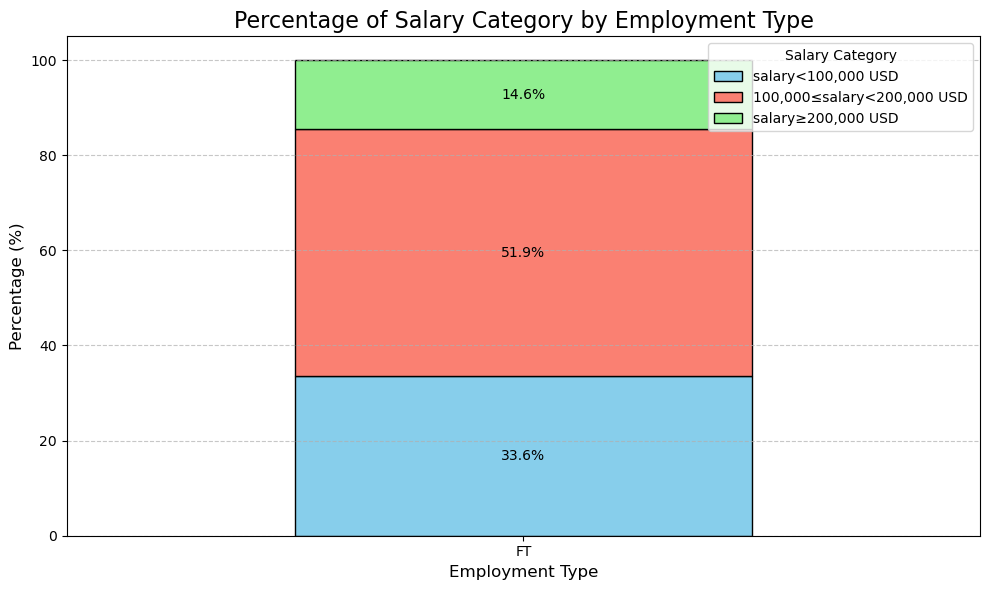

In [87]:
emp_salary = (
    data.groupby(['employment_type', 'salary_category']).size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum() * 100, axis=1)
)

# Plot the stacked bar chart
ax = emp_salary.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

plt.title('Percentage of Salary Category by Employment Type', fontsize=16)
plt.xlabel('Employment Type', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)

# Add percentages on each section of the bars
for i, bar in enumerate(ax.containers):
    for j, rect in enumerate(bar):
        height = rect.get_height()
        if height > 0:
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + height / 2,
                f'{height:.1f}%',
                ha='center',
                va='center'
            )

plt.legend(title='Salary Category', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [88]:
emp_salary2 = data.groupby('experience_level')['salary_in_usd'].mean()
emp_salary2

experience_level
EN     72648.685185
MI    101828.783133
SE    156060.680606
Name: salary_in_usd, dtype: float64

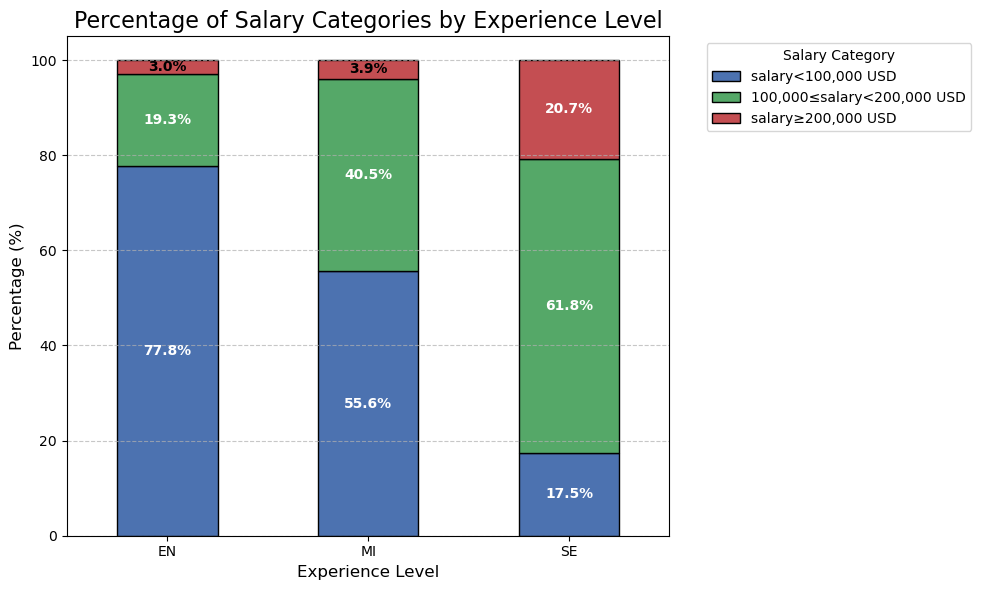

In [89]:
# Calculate the count of each salary category within each experience level
salary_exp_counts = data.groupby(['experience_level', 'salary_category']).size().unstack(fill_value=0)

# Convert counts to percentages within each experience level
salary_exp_percentages = salary_exp_counts.div(salary_exp_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
ax = salary_exp_percentages.plot(
    kind='bar', 
    stacked=True, 
    color=['#4c72b0', '#55a868', '#c44e52'], 
    edgecolor='black',
    figsize=(10, 6)
)

# Add title and labels
plt.title('Percentage of Salary Categories by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on each segment of the bars
for i, experience_level in enumerate(salary_exp_percentages.index):
    cumulative = 0  # Track cumulative height for each bar segment
    for j, (category, percentage) in enumerate(salary_exp_percentages.loc[experience_level].items()):
        if percentage > 0:  # Only label non-zero percentages
            cumulative += percentage
            ax.text(
                i,  # x position
                cumulative - (percentage / 2),  # y position
                f'{percentage:.1f}%', 
                ha='center', 
                va='center', 
                color='white' if percentage > 10 else 'black',  # Contrast for readability
                fontsize=10, 
                fontweight='bold'
            )

plt.xticks(rotation=0)
plt.legend(title='Salary Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [90]:
emp_salary3 = data.groupby('remote_ratio')['salary_in_usd'].mean()
emp_salary3

remote_ratio
0      143690.173693
50      78486.609626
100    131821.666391
Name: salary_in_usd, dtype: float64

<Figure size 1000x600 with 0 Axes>

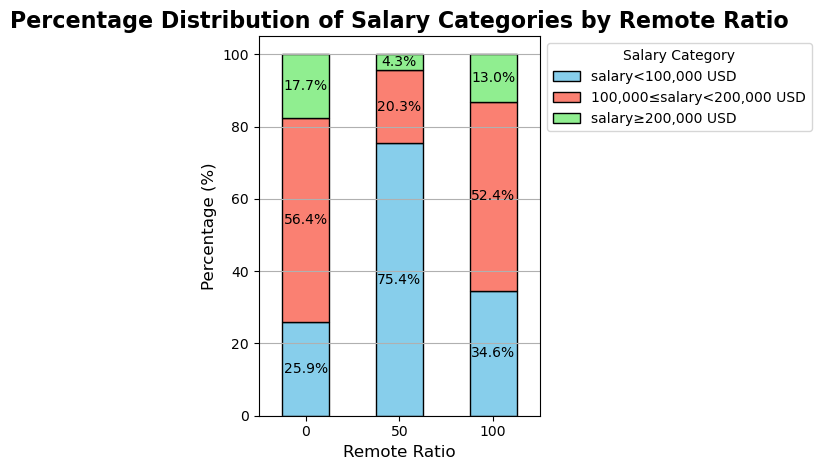

In [91]:
# Calculate the percentage of each salary category within each remote ratio
emp_salary_percent = (
    data.groupby('remote_ratio')['salary_category']
    .value_counts(normalize=True)
    .rename('percentage')
    .reset_index()
)
emp_salary_percent['percentage'] *= 100  # Convert to percentage

# Pivot the data to get 'remote_ratio' as rows and 'salary_category' as columns
emp_salary_pivot = emp_salary_percent.pivot(index='remote_ratio', columns='salary_category', values='percentage')

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
emp_salary_pivot.plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'], edgecolor='black')

plt.title('Percentage Distribution of Salary Categories by Remote Ratio', fontsize=16, fontweight='bold')
plt.xlabel('Remote Ratio', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on each section of the bars
for i, remote_ratio in enumerate(emp_salary_pivot.index):
    cumulative_percentage = 0
    for salary_category in emp_salary_pivot.columns:
        percentage = emp_salary_pivot.loc[remote_ratio, salary_category]
        if percentage > 0:
            plt.text(
                i, cumulative_percentage + percentage / 2,
                f"{percentage:.1f}%", ha='center', va='center', color="black", fontsize=10
            )
        cumulative_percentage += percentage

plt.xticks(rotation=0)  
plt.legend(title='Salary Category', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [92]:
emp_salary4 = data.groupby('company_size')['salary_in_usd'].mean()
emp_salary4

company_size
L    113202.239609
M    141474.514300
S     78364.278912
Name: salary_in_usd, dtype: float64

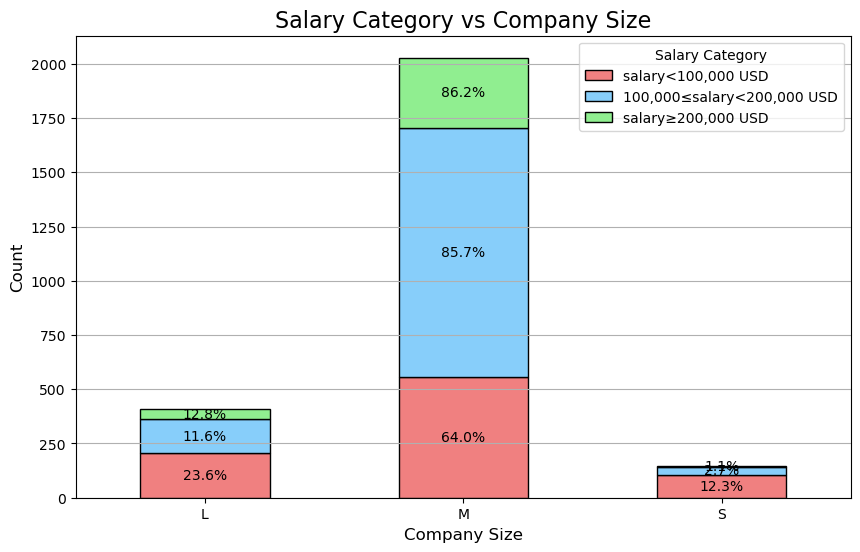

In [93]:
grouped_data = data.groupby(['company_size', 'salary_category']).size().reset_index(name='count')

# Pivot the data for stacking
pivot_df = grouped_data.pivot_table(index='company_size', columns='salary_category', values='count', fill_value=0)

# Create a stacked bar plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightcoral', 'lightskyblue', 'lightgreen'], edgecolor='black')

# Calculate percentage and add to the bars
for container in ax.containers:
    labels = []
    for bar in container:
        height = bar.get_height()
        total = sum([bar.get_height() for bar in container])
        percentage = (height / total) * 100 if total > 0 else 0
        labels.append(f'{percentage:.1f}%')

    # Add percentage labels on the bars
    ax.bar_label(container, labels=labels, label_type='center')

# Adding titles and labels
plt.title('Salary Category vs Company Size', fontsize=16)
plt.xlabel('Company Size', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.xticks(rotation=0)  
plt.grid(axis='y')  
plt.legend(title='Salary Category')
plt.show()

In [94]:
emp_salary5 = data.groupby('company_location')['salary_in_usd'].mean()
emp_salary5

company_location
GB     87685.000000
US    136327.050226
Name: salary_in_usd, dtype: float64

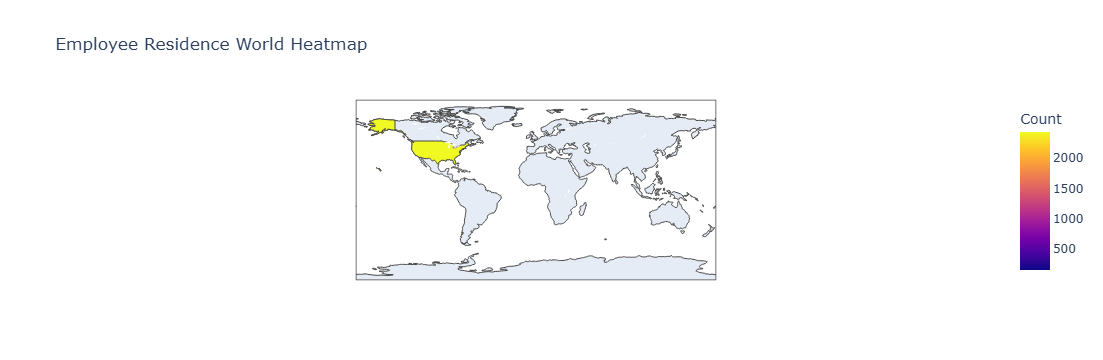

In [95]:
import plotly.express as px

# Grouping data to count occurrences by 'employee_residence'
data1 = {
    'Country': data.groupby('employee_residence').size().index.tolist(),
    'Count': data.groupby('employee_residence').size().tolist()
}

# Create DataFrame
df = pd.DataFrame(data1)

# Plotting the choropleth map
fig = px.choropleth(df,
                    locations='Country',
                    locationmode='country names',
                    color='Count',
                    hover_name='Country',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Employee Residence World Heatmap',
                    range_color=[df['Count'].min(), df['Count'].max()])  # Dynamic color scale range

# Show the plot
fig.show()


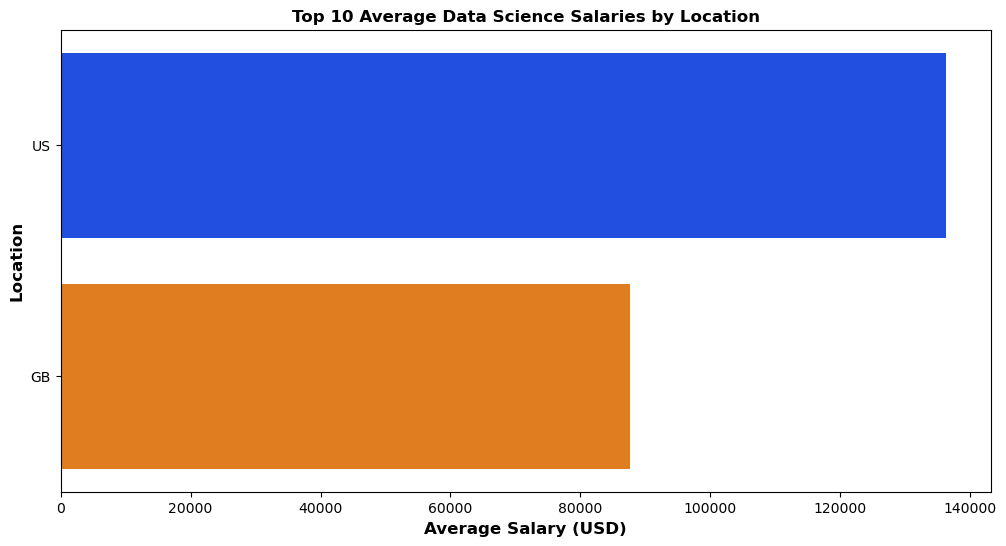

In [96]:
emp_salary5 = emp_salary5.sort_values(ascending=False)

emp_salary5_df = emp_salary5.reset_index()

top_n_locations = 10

plt.figure(figsize=(12, 6))
sns.barplot(x='salary_in_usd', y='company_location', data=emp_salary5_df.head(top_n_locations), palette='bright')

plt.title(f'Top {top_n_locations} Average Data Science Salaries by Location', fontsize=12, fontweight='bold')
plt.xlabel('Average Salary (USD)', fontsize=12, fontweight='bold')
plt.ylabel('Location', fontsize=12, fontweight='bold')

plt.show()


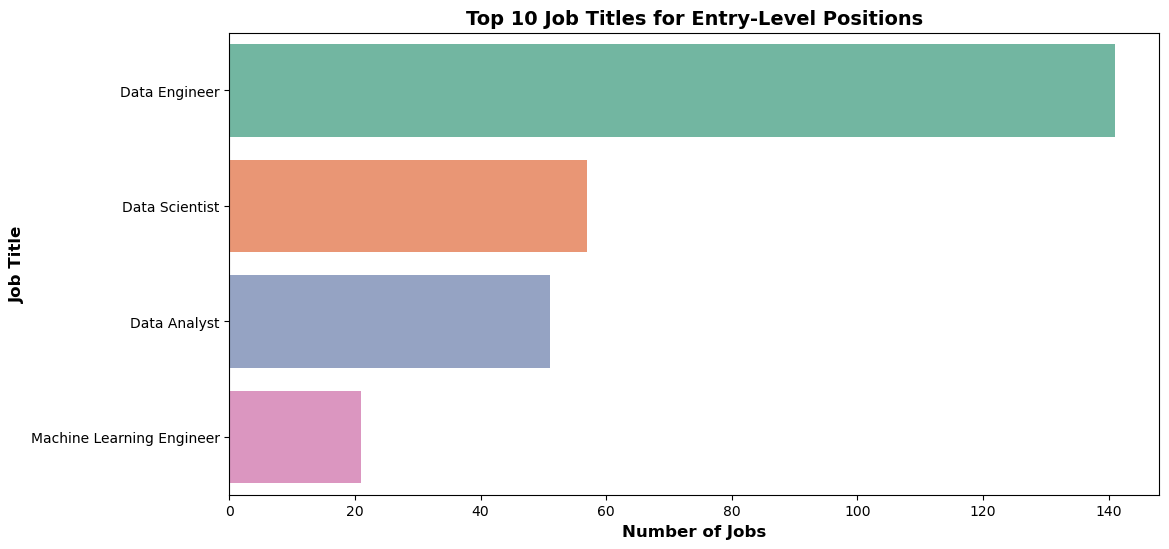

In [97]:
entry_level_jobs = data[data['experience_level'] == 'EN']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Entry-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

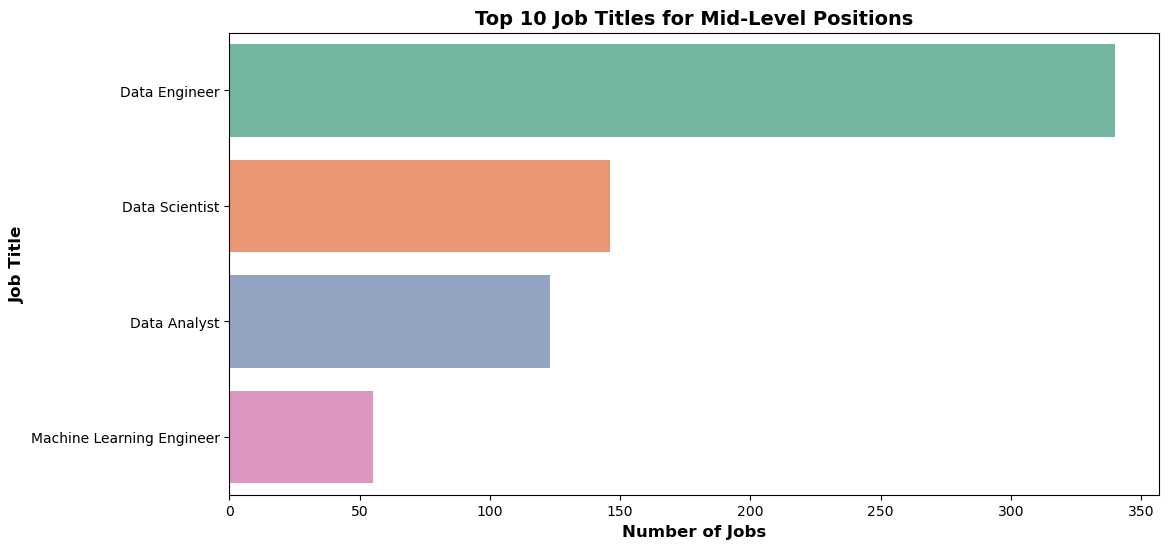

In [98]:
entry_level_jobs = data[data['experience_level'] == 'MI']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Mid-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

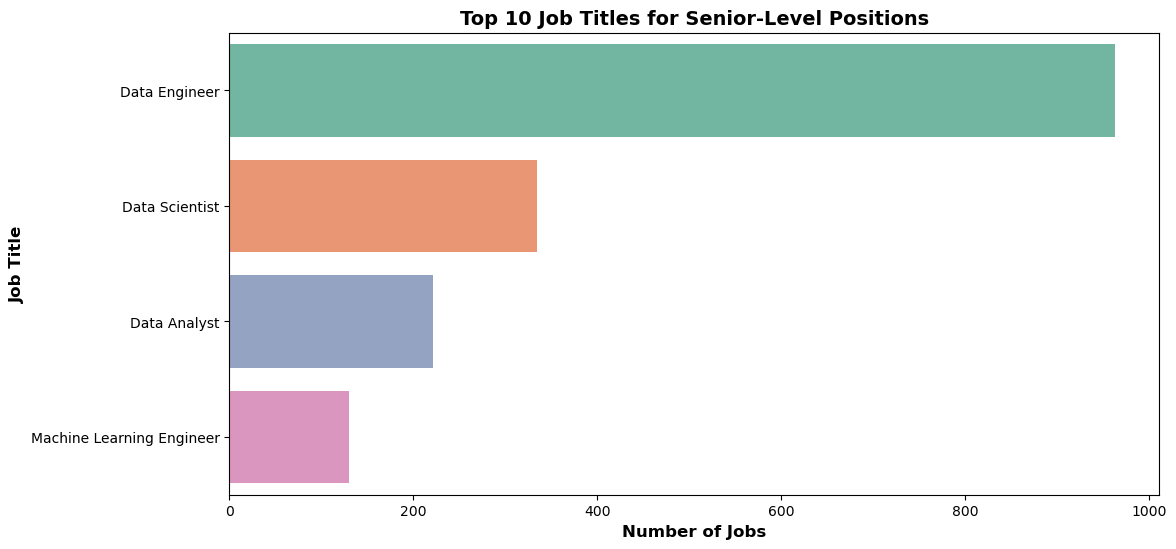

In [99]:
entry_level_jobs = data[data['experience_level'] == 'SE']

job_title_counts = entry_level_jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=job_title_counts.values, y=job_title_counts.index, palette='Set2')

plt.title('Top 10 Job Titles for Senior-Level Positions', fontsize=14, fontweight='bold')
plt.xlabel('Number of Jobs', fontsize=12, fontweight='bold')
plt.ylabel('Job Title', fontsize=12, fontweight='bold')

plt.show()

               work_year    salary  salary_in_usd  remote_ratio
work_year       1.000000 -0.099153       0.236958     -0.219160
salary         -0.099153  1.000000      -0.043672      0.026485
salary_in_usd   0.236958 -0.043672       1.000000     -0.084502
remote_ratio   -0.219160  0.026485      -0.084502      1.000000


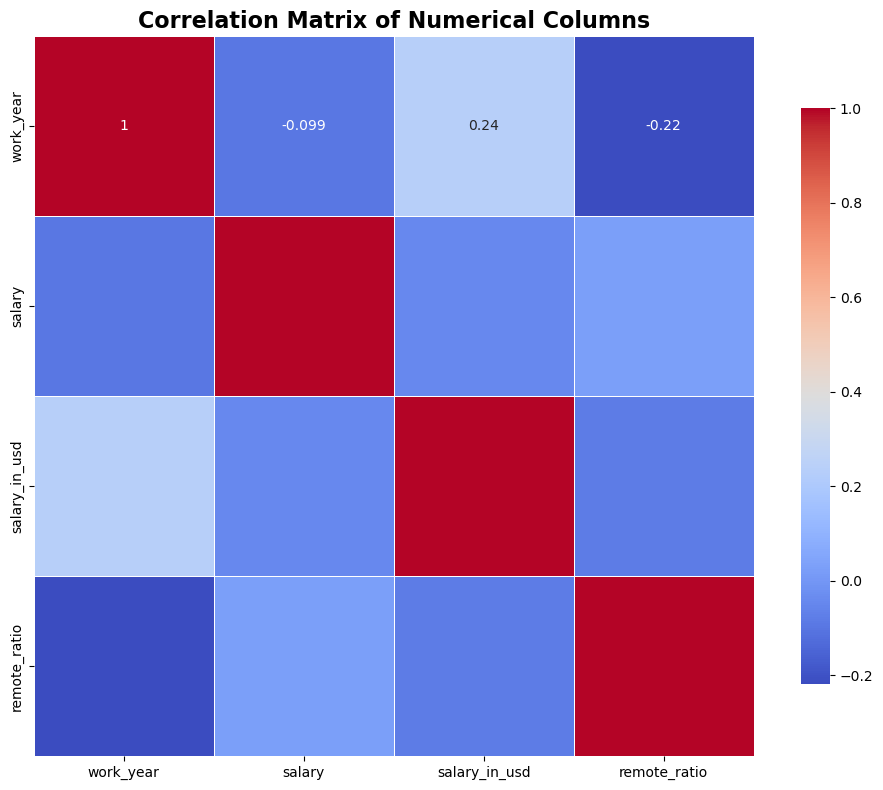

In [100]:
# Select only numerical columns (int and float types)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_data = data[numerical_columns]

# Calculate the correlation matrix for numerical columns only
correlation_matrix = numerical_data.corr()

# Print the correlation matrix
print(correlation_matrix)

# Set the size of the plot
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix of Numerical Columns', fontsize=16, fontweight='bold')

# Show the plot with adjusted layout
plt.tight_layout()
plt.show()

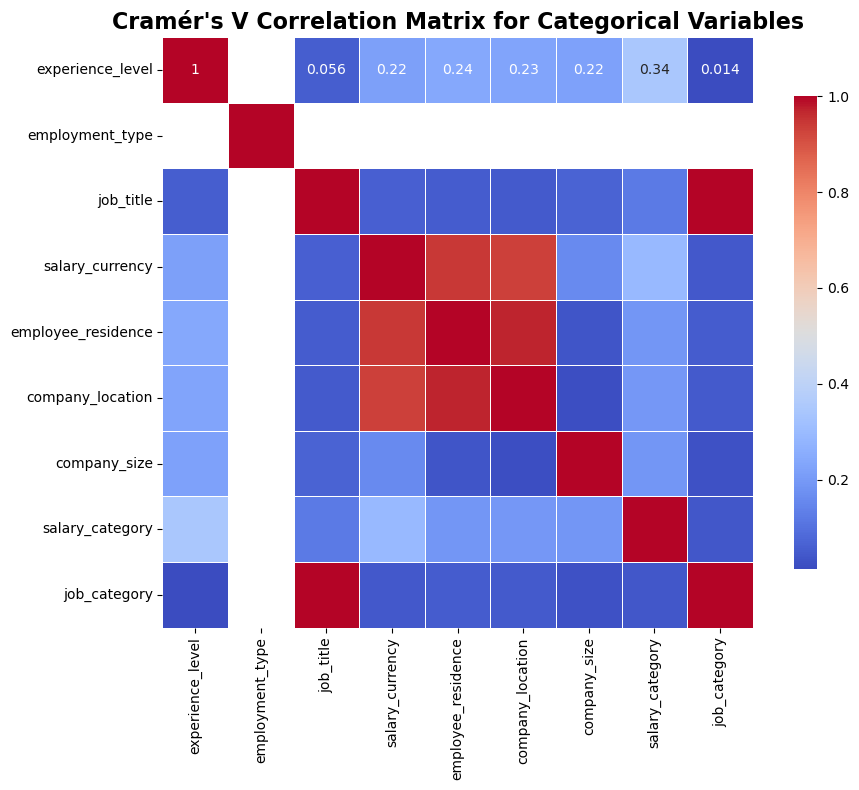

In [103]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k, r) - 1)))

# Ensure that categorical columns selected
categorical_columns = data.select_dtypes(include=['object', 'category']).columns

# Initialize an empty DataFrame to hold Cramér's V values
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns, dtype=float)

# Calculate Cramér's V for each pair of categorical variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            confusion_matrix = pd.crosstab(data[col1], data[col2])
            cramers_v_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Plotting the Cramér's V matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, cbar_kws={"shrink": .8})

plt.title("Cramér's V Correlation Matrix for Categorical Variables", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

X = data[numerical_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data["feature"] = numerical_columns

vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print(vif_data)

         feature       VIF
0      work_year  1.115078
1         salary  1.010387
2  salary_in_usd  1.061197
3   remote_ratio  1.051715


## Model Fiiting

In [105]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,salary_category,job_category
0,2023,SE,FT,Data Engineer,80000,EUR,85847,US,100,US,L,"salary<100,000 USD",Data Engineering
1,2023,MI,FT,Data Engineer,30000,USD,30000,US,100,US,S,"salary<100,000 USD",Data Engineering
2,2023,MI,FT,Data Engineer,25500,USD,25500,US,100,US,S,"salary<100,000 USD",Data Engineering
3,2023,SE,FT,Data Scientist,175000,USD,175000,US,100,US,M,"100,000≤salary<200,000 USD",Data Science
4,2023,SE,FT,Data Scientist,120000,USD,120000,US,100,US,M,"100,000≤salary<200,000 USD",Data Science


In [106]:
data.drop(['salary_in_usd','job_title'],axis=1,inplace= True)
data.head()

,work_year,experience_level,employment_type,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_category,job_category
0,2023,SE,FT,80000,EUR,US,100,US,L,"salary<100,000 USD",Data Engineering
1,2023,MI,FT,30000,USD,US,100,US,S,"salary<100,000 USD",Data Engineering
2,2023,MI,FT,25500,USD,US,100,US,S,"salary<100,000 USD",Data Engineering
3,2023,SE,FT,175000,USD,US,100,US,M,"100,000≤salary<200,000 USD",Data Science
4,2023,SE,FT,120000,USD,US,100,US,M,"100,000≤salary<200,000 USD",Data Science


In [107]:
data['salary_category_numeric'] = data['salary_category'].astype('category').cat.codes + 1

# Displaying the result
data[['salary_category', 'salary_category_numeric']].head()

,salary_category,salary_category_numeric
0,"salary<100,000 USD",1
1,"salary<100,000 USD",1
2,"salary<100,000 USD",1
3,"100,000≤salary<200,000 USD",2
4,"100,000≤salary<200,000 USD",2


In [108]:
data.drop(['salary_category'],axis=1,inplace= True)
data.head()

,work_year,experience_level,employment_type,salary,salary_currency,employee_residence,remote_ratio,company_location,company_size,job_category,salary_category_numeric
0,2023,SE,FT,80000,EUR,US,100,US,L,Data Engineering,1
1,2023,MI,FT,30000,USD,US,100,US,S,Data Engineering,1
2,2023,MI,FT,25500,USD,US,100,US,S,Data Engineering,1
3,2023,SE,FT,175000,USD,US,100,US,M,Data Science,2
4,2023,SE,FT,120000,USD,US,100,US,M,Data Science,2


In [109]:
data = pd.get_dummies(data,columns=['experience_level','salary_currency','employment_type', 'employee_residence', 'company_location', 'company_size','job_category'],dtype=int)

In [110]:
data.head()

,work_year,salary,remote_ratio,salary_category_numeric,experience_level_EN,experience_level_MI,experience_level_SE,salary_currency_EUR,salary_currency_GBP,salary_currency_USD,...,employee_residence_GB,employee_residence_US,company_location_GB,company_location_US,company_size_L,company_size_M,company_size_S,job_category_Data Engineering,job_category_Data Science,job_category_Machine Learning
0,2023,80000,100,1,0,0,1,1,0,0,...,0,1,0,1,1,0,0,1,0,0
1,2023,30000,100,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,1,0,0
2,2023,25500,100,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,1,0,0
3,2023,175000,100,2,0,0,1,0,0,1,...,0,1,0,1,0,1,0,0,1,0
4,2023,120000,100,2,0,0,1,0,0,1,...,0,1,0,1,0,1,0,0,1,0


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2584 entries, 0 to 3754
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   work_year                      2584 non-null   int64
 1   salary                         2584 non-null   int64
 2   remote_ratio                   2584 non-null   int64
 3   salary_category_numeric        2584 non-null   int8 
 4   experience_level_EN            2584 non-null   int32
 5   experience_level_MI            2584 non-null   int32
 6   experience_level_SE            2584 non-null   int32
 7   salary_currency_EUR            2584 non-null   int32
 8   salary_currency_GBP            2584 non-null   int32
 9   salary_currency_USD            2584 non-null   int32
 10  employment_type_FT             2584 non-null   int32
 11  employee_residence_GB          2584 non-null   int32
 12  employee_residence_US          2584 non-null   int32
 13  company_location_GB    

In [112]:
X = data.drop('salary_category_numeric',axis=1)
y = data['salary_category_numeric']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [113]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix 
from collections import Counter
print("Original class distribution:", Counter(y)) 

Original class distribution: Counter({2: 1341, 1: 867, 3: 376})


In [114]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution of the resampled data
print("SMOTE class distribution:", Counter(y_resampled))

# Optional: You can also print the shape of the resampled dataset
print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


SMOTE class distribution: Counter({3: 1081, 1: 1081, 2: 1081})
Resampled X shape: (3243, 20)
Resampled y shape: (3243,)


In [115]:
print("Unique classes in y_resampled:", np.unique(y_resampled))

Unique classes in y_resampled: [1 2 3]


In [116]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord as m
import warnings
warnings.simplefilter(action='ignore')

# Define models with parameter grids for hyperparameter tuning
model_params = {
    'Ordinal Logistic Regression': {
        'model': m.LogisticAT(),  # Using Mord's LogisticAT for ordinal regression
        'params': {
            'alpha': [0.1, 0.5, 1.0]  # Regularization parameter
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15]
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {}
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7]
        }
    }
   
}

# Loop through each model and perform hyperparameter tuning with GridSearchCV
for name, model_dict in model_params.items():
    print(f"Training {name} with hyperparameter tuning...")
    grid_search = GridSearchCV(model_dict['model'], model_dict['params'], cv=5, scoring='accuracy')
    
    # Fit with the resampled SMOTE data
    grid_search.fit(X_resampled, y_resampled)
    
    best_model = grid_search.best_estimator_
    
    # Training predictions and metrics
    train_pred = best_model.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)
    train_err = 1 - train_acc
    train_f1 = f1_score(y_resampled, train_pred, average='weighted')
    train_cm = confusion_matrix(y_resampled, train_pred)
    train_sensitivity = train_cm[1, 1] / (train_cm[1, 1] + train_cm[1, 0]) if (train_cm[1, 1] + train_cm[1, 0]) != 0 else 0
    train_specificity = train_cm[0, 0] / (train_cm[0, 0] + train_cm[0, 1]) if (train_cm[0, 0] + train_cm[0, 1]) != 0 else 0
    
    # Test predictions and metrics
    test_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_err = 1 - test_acc
    test_f1 = f1_score(y_test, test_pred, average='weighted')
    test_cm = confusion_matrix(y_test, test_pred)
    test_sensitivity = test_cm[1, 1] / (test_cm[1, 1] + test_cm[1, 0]) if (test_cm[1, 1] + test_cm[1, 0]) != 0 else 0
    test_specificity = test_cm[0, 0] / (test_cm[0, 0] + test_cm[0, 1]) if (test_cm[0, 0] + test_cm[0, 1]) != 0 else 0
    
    # Print results
    print(name)
    print('=' * len(name))
    print(f'Best Parameters: {grid_search.best_params_}')
    print(f'Training Accuracy: {train_acc:.4f}')
    print(f'Training Error Rate: {train_err:.4f}')
    print(f'Training F1 Score: {train_f1:.4f}')
    print(f'Training Confusion Matrix:\n{train_cm}')
    print(f'Training Sensitivity: {train_sensitivity:.4f}')
    print(f'Training Specificity: {train_specificity:.4f}')
    print('\n')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Error Rate: {test_err:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print(f'Test Confusion Matrix:\n{test_cm}')
    print(f'Test Sensitivity: {test_sensitivity:.4f}')
    print(f'Test Specificity: {test_specificity:.4f}')
    print('\n' + '=' * 30 + '\n')


Training Ordinal Logistic Regression with hyperparameter tuning...
Ordinal Logistic Regression
Best Parameters: {'alpha': 0.5}
Training Accuracy: 0.3370
Training Error Rate: 0.6630
Training F1 Score: 0.1744
Training Confusion Matrix:
[[  12 1069    0]
 [   0 1081    0]
 [   0 1081    0]]
Training Sensitivity: 1.0000
Training Specificity: 0.0111


Test Accuracy: 0.5106
Test Error Rate: 0.4894
Test F1 Score: 0.3534
Test Confusion Matrix:
[[  4 175   0]
 [  0 260   0]
 [  0  78   0]]
Test Sensitivity: 1.0000
Test Specificity: 0.0223


Training Random Forest with hyperparameter tuning...
Random Forest
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Training Accuracy: 0.9978
Training Error Rate: 0.0022
Training F1 Score: 0.9978
Training Confusion Matrix:
[[1076    5    0]
 [   0 1079    2]
 [   0    0 1081]]
Training Sensitivity: 1.0000
Training Specificity: 0.9954


Test Accuracy: 0.9787
Test Error Rate: 0.0213
Test F1 Score: 0.9787
Test Confusion Matrix:
[[175   2   2]
 [  5 255  